In [1]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
initializers = tf.keras.initializers

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data_generator import generator
from encoding.layers import IntegerBaseEncoder, FloatBaseEncoder

2023-02-06 22:01:37.865485: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [34]:
seed = 123
tf.random.set_seed(seed)
n_samples = 1000
n_features = 1
mean = 1
std = 0.6

for dist_name in ['normal', 'exponential', 'lognormal']:
    gen = generator.DataGenerator(mean=mean, std=std, dist=dist_name)
    x, y = gen.generate(n_features=n_features, n_samples=n_samples)
    x = np.ravel(x)
    order = np.argsort(x).reshape(-1, 1)
    x, y = x[order], y[order]
    exec(f'x_{dist_name}=x\ny_{dist_name}=y')

In [35]:
x_array = ['x_normal', 'x_exponential', 'x_lognormal']
y_array = ['y_normal', 'y_exponential', 'y_lognormal']

In [36]:
standard = lambda x:(x - x.mean())/x.std()

transform_layer = FloatBaseEncoder()
transform_layer_only_integers = FloatBaseEncoder(only_integers=True)
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'binary explosion o/i': lambda x: transform_layer_only_integers(x).squeeze(1),
                  'higher dimensionality': lambda x, n=5: np.power(x, np.arange(1, n))}

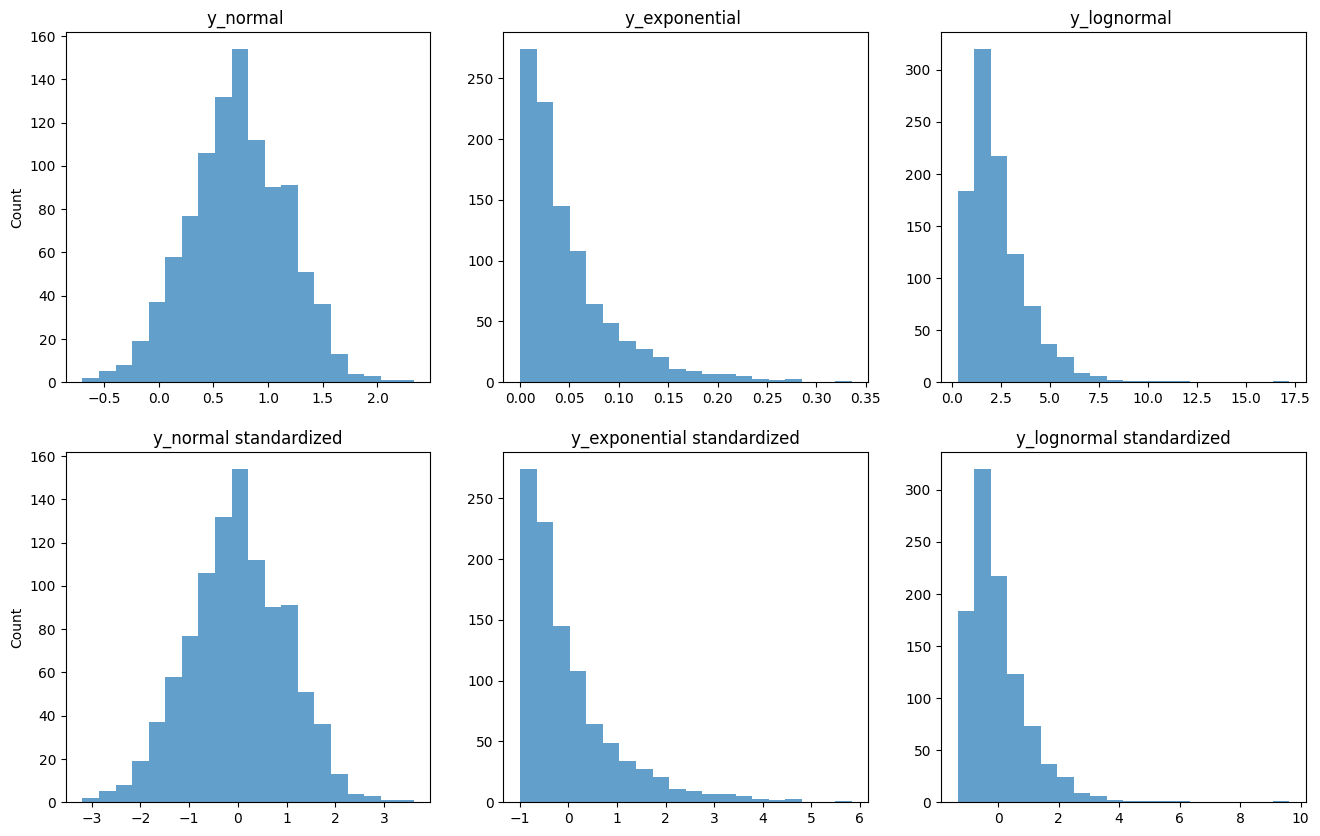

In [37]:
fig, ax = plt.subplots(2, len(y_array), figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate(y_array):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

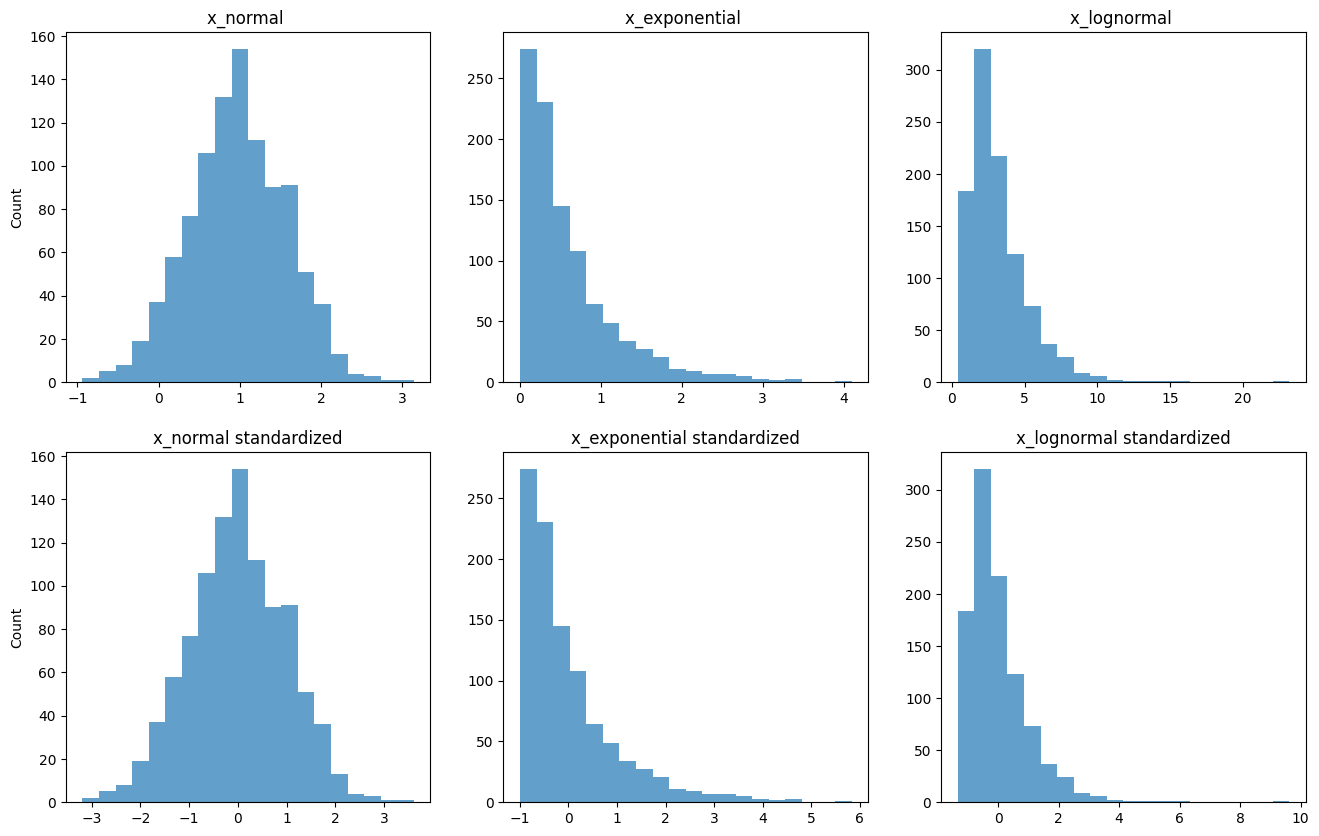

In [38]:
fig, ax = plt.subplots(2, len(x_array), figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate(x_array):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

2023-02-06 22:01:41.053462: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-06 22:01:41.054308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-06 22:01:41.086246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 22:01:41.086391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2023-02-06 22:01:41.086407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-06 22:01:41.087900: I tensorflow/stream_executor/platform/d

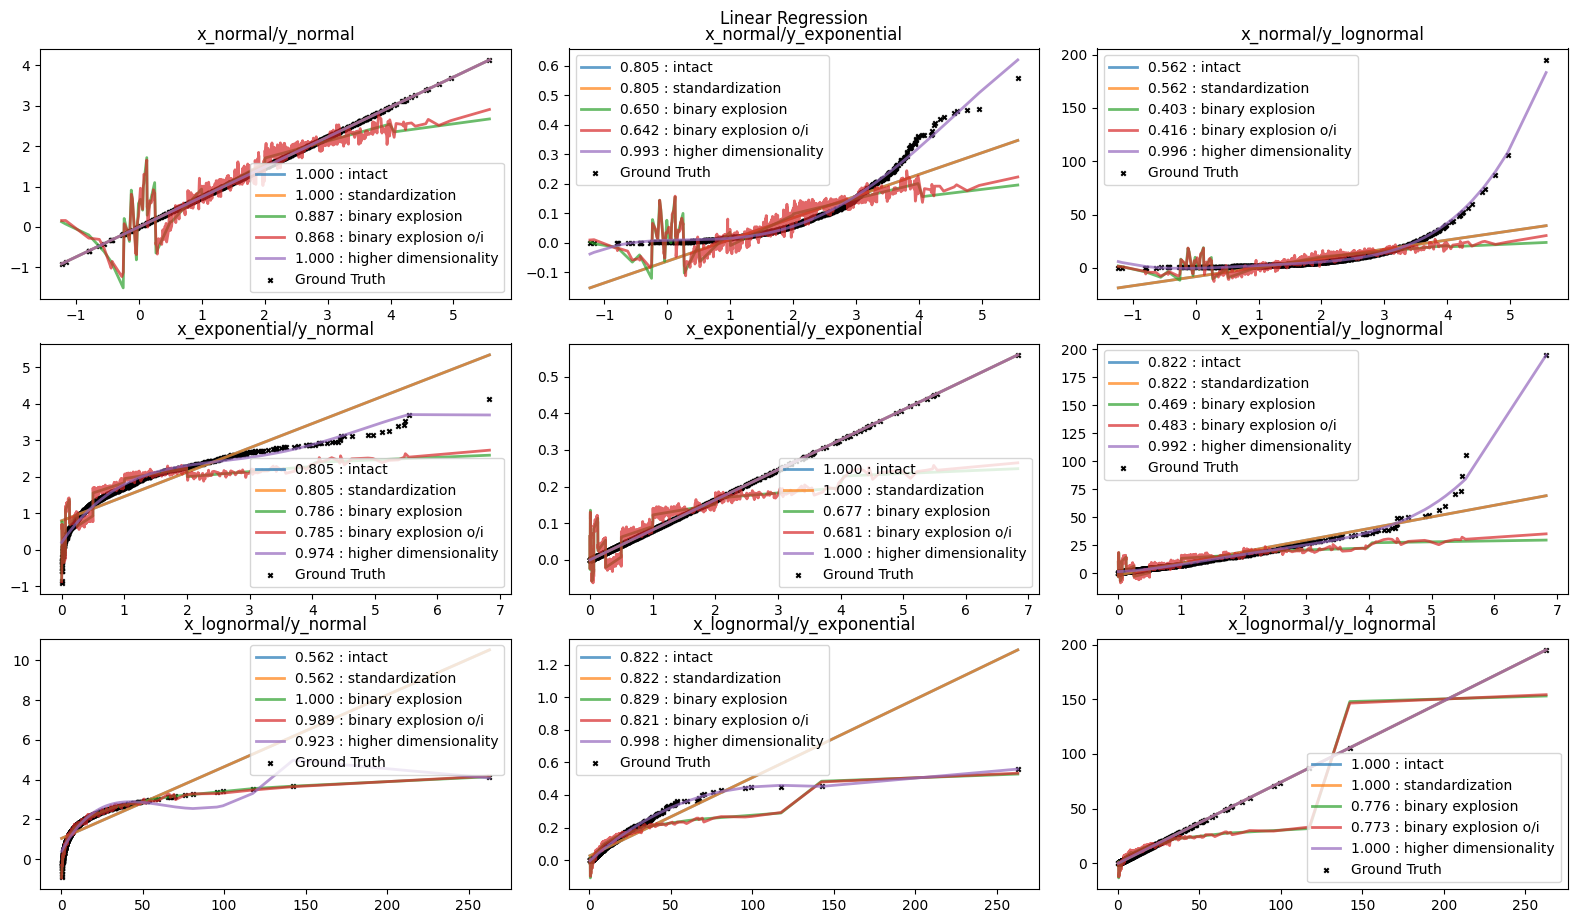

In [7]:
fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()


baseline = LinearRegression

for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            
            model = baseline()
            model.fit(transformed_x, cur_y)
                        
            y_hat = model.predict(transformed_x)
            score = model.score(transformed_x, cur_y)
            ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=2, label=f'{score:0.3f} : {name_transformation}')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('Linear Regression', y=1.02)
plt.show()

In [8]:
class _MLPBlock(keras.layers.Layer):
    def __init__(self, width, droprate=0, regularization=keras.regularizers.L1L2(0), **kwargs):
        super(_MLPBlock, self).__init__()
        self.dense = layers.Dense(width, 
                                  kernel_initializer=initializers.RandomNormal(seed=seed),
                                  kernel_regularizer=regularization, **kwargs)
#         self.activation = layers.ReLU()
#         self.drop = layers.Dropout(droprate)
#         self.bn = layers.BatchNormalization()
        
    def call(self, inputs, **kwargs):
        x = self.dense(inputs)
#         x = self.activation(x)
#         x = self.drop(x)
#         x = self.bn(x)
        return x

# implement policy network
class MLP(keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=64, depth=1, **kwargs):
        super().__init__()
        self.depth = depth
        self.hidden_0 = _MLPBlock(hidden_dim, input_shape=(input_dim,), **kwargs)

        for i in range(1, depth):
            setattr(self, f'hidden_{i}', _MLPBlock(hidden_dim))
        self.out = _MLPBlock(output_dim)

    
    def call(self, inputs):
        x = inputs
        for i in range(self.depth):
            x = getattr(self, f'hidden_{i}')(x)
        x = self.out(x)
        return x

2023-02-06 22:01:43.552938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-06 22:01:43.572667: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz
2023-02-06 22:01:43.832288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


8.715639426621683e-06 : intact
4.439540101079915e-07 : standardization
0.0005982463455368183 : binary explosion
0.00010545832999540445 : binary explosion o/i
6.261504231662829e-05 : higher dimensionality
5.664635082966429e-06 : intact
0.00014172622521506538 : standardization
7.019386988506935e-06 : binary explosion
1.9717390333855866e-05 : binary explosion o/i
0.00045410155736463626 : higher dimensionality
0.05058865482157323 : intact
0.031562411473945604 : standardization
0.5496662229780703 : binary explosion
0.04657183864685067 : binary explosion o/i
0.0007141336320518533 : higher dimensionality
0.0025130440668987178 : intact
0.0009191208375625597 : standardization
0.0001823093018883289 : binary explosion
0.00021896151402266346 : binary explosion o/i
0.0004944419234344513 : higher dimensionality
6.384966540795508e-08 : intact
1.3939060346984703e-08 : standardization
5.904904102894546e-07 : binary explosion
2.302097841048953e-06 : binary explosion o/i
1.940072029493252e-05 : higher di

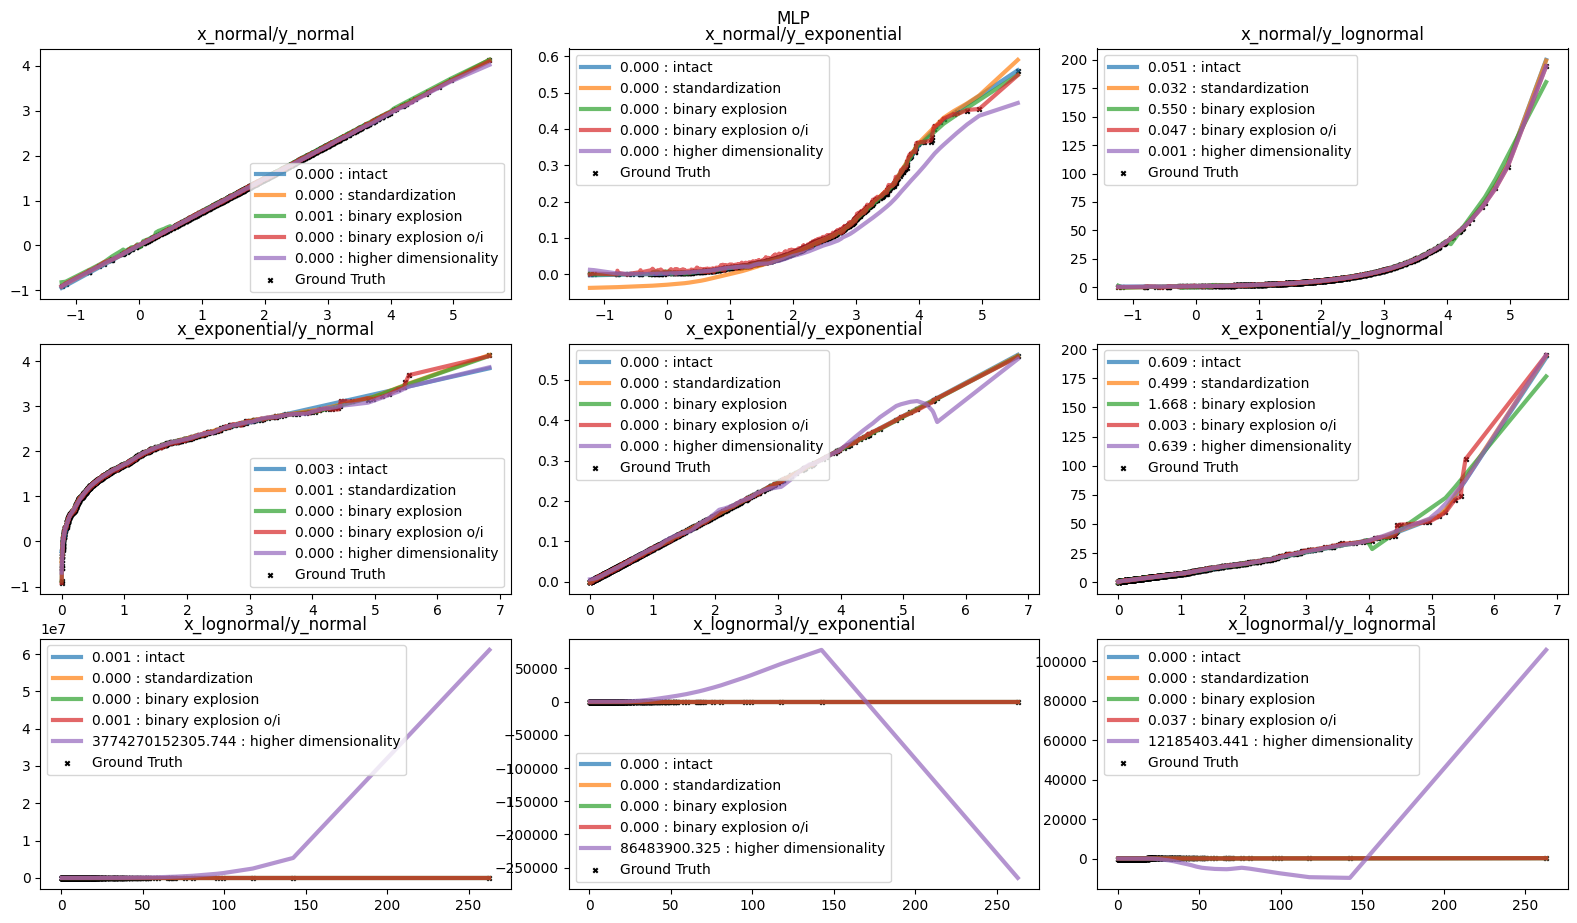

In [9]:
fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()


activation = activation=keras.activations.relu


for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)
        

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            try:
                model = MLP(transformed_x.shape[1], 1, 1024, depth=2, activation=activation)
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
                model.fit(transformed_x, cur_y, epochs=1000, verbose=0)
                y_hat = model.predict(transformed_x)
                score = mse(y_hat, cur_y)
                print(f"{score} : {name_transformation}")
                ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
            except:
                print(name_transformation, 'NANS')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()